# 2η Εργαστηριακή Άσκηση: **Μη επιβλεπόμενη μάθηση**
---
**Ομάδα 08** \\
Βεκράκης Εμμανουήλ - 03116068 \\
Κρανιάς Δημήτριος - 03116030 \\
Μισιακός Παναγιώτης - 03116351 \\

In [ ]:
# All packages that we need
!pip install pip --upgrade #upgrade pip package installer
!pip install scikit-learn --upgrade #upgrade scikit-learn package
!pip install numpy --upgrade #upgrade numpy package
!pip install pandas --upgrade #upgrade pandas package
!pip install matplotlib --upgrade #upgrade matplotlib package
!pip install joblib --upgrade #upgrade joblib package
!pip install somoclu --upgrade #upgrade somoclu package

In [30]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
np.set_printoptions(linewidth=200)
import pandas as pd
from tqdm.notebook import tqdm
import joblib
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.corpus import names
import string
from nltk.stem.porter import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('names')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

!pip install --upgrade somoclu
import somoclu

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


## Εισαγωγή του Dataset

Αρχικά, με τον τρόπο που περιγράφεται στην εκφώνηση εισάγουμε τα δεδομένα ταινιών με τα οποία θα εργαστούμε. Τα δεδομένα αυτά αποτελούνται από $5000$ ταινίες για τις οποίες γνωρίζουμε id, title, categories και summary.

In [3]:
dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

Διαλέγουμε το corpus που αντιστοιχεί στην ομάδα μας. Το team seed number μας είναι 8.

In [4]:
# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 8

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1EA_pUIgK5Ub3kEzFbFl8wSRqAV6feHqD"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο

Σαν πρώτη εφαρμογή θα κατασκευάσουμε ένα σύστημα συστάσεων ταινιών. Το σύστημα αυτό αρχικά θα επιχειρίσει να απεικονίσει τις ταινίες σε έναν πολυδιάστατο διανυσματικό χώρο και έπειτα θα θεωρεί παρόμοιες ταινίες αυτές που έχουν μικρή απόσταση "συνημιτόνου".

## Μετατροπή σε TFIDF

Σαν πρώτο βήμα εφαρμόζουμε μετασχηματισμό tf-idf στο corpus με τις περιλήψεις των ταινιών. Με αυτόν τον τρόπο εξάγουμε το Vector Space Model, με βάση το οποίο θα κάνουμε τις συστάσεις ταινιών υπολογίζοντας τις κοντινότερες, ως προς την απόσταση συνημιτόνου, ταινίες.

Σημειώνουμε πως ο μετασχηματισμός αυτός δεν είναι ο βέλτιστος, ούτε ως προς τις συστάσεις, ούτε ως προς την διαστατικότητα των δεδομένων. Ο μοναδικός λόγος που εκτελούμε τον μετασχηματισμό είναι για αναφορά σε παρακάτω βήμα όπου θα τον συγκρίνουμε με το μοντέλο που επιχειρούμε να βελτιστοποιήσουμε.

In [5]:
# Original tf-idf transform
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

# Save sub-optimal model for future reference
joblib.dump(corpus_tf_idf, 'tf_idf_original.pkl')

# Print shape to show dimensionality
print(corpus_tf_idf.shape)

(5000, 49103)


Όπως παρατηρούμε, το αρχικό --μή βέλτιστο-- μοντέλο έχει μεγάλη διαστασικότητα συγκριτικά με το βέλτιστο που θα παράξουμε παρακάτω.

## Υλοποίηση του συστήματος συστάσεων

Παρακάτω υλοποιούμε την συνάρτηση `content_recommender`, η οποία για μία δοθείσα ταινία μας επιστρέφει τα ids των όμοιων της ταινιών. Για να επιτευχθεί αυτό, πρώτα υλοποιούμε δύο βοηθητικές συναρτήσεις που θα απλοποιήσουν την συνολική υλοποίηση. Η πρώτη αφορά τον υπολογισμό της ομοιότητας συνημιτόνου μίας `target_movie` με όλες τις υπόλοιπες ταινίες του corpus, ενώ η δεύτερη υπολογίζει τους δείκτες που αντιστοιχούν στον ταξινομημένο κατά φθίνουσα σειρά ομοιότητας πίνακα ταινιών.

In [6]:
def cos_sim(target_movie):
    '''
        Helper function to compute cosine similarity with all movies
    '''
    # Initializing array of similarities
    similarity = np.zeros(corpus_tf_idf.shape[0])
    
    for i in range(corpus_tf_idf.shape[0]):
        # Compute similarity of target movie with i-th movie
        similarity[i] = cosine_similarity(corpus_tf_idf[target_movie], corpus_tf_idf[i])
      
    return similarity


def arg_sort(array):
    '''
        Helper function to get sorted movie id's in descending order
    '''
    # Compute indices of descending order
    arg_sorted_array = np.argsort((-1) * array) #Multiplying by -1 to get sorted array in descending order
    
    return arg_sorted_array


def content_recommender(target_movie, max_recommendations, info=True):
    '''
        Content based recommender system function

        -- Input --
        target_movie (int): Id of target movie
        max_recommendations (int): maximum number of similar movies to recommend
        info (boolean): whether to print or not information (id, summary, categories) for each movie

        -- Output --
        (list): ids of target movie together with ids of max_recommendation movies
    '''
    
    # Computing cosine similarity with all movies
    similarity = cos_sim(target_movie)
    
    # Computing indices of movies in descending order of cosine similarity -- 0-th movie is the target_movie itself
    id_sorted = arg_sort(similarity)

    # Printing movie id, title, summary and categories
    print("*** Target movie ***")
    if (info):
      print("Movie ID:", target_movie)
    print("Title:", titles[target_movie][0])
    if (info):
      print("Summary:", summaries[target_movie][0])
      print("Categories:", categories[target_movie][0], "\n")
    
    # Printing recommendations
    print("*** Top", max_recommendations, "recommended movies based on content ***", "\n")
    for i in range(max_recommendations):
        # id, title, summary and categories
        if (info):
          print("*** Recommended movie No.", i + 1, "***")
          print("Movie ID:", id_sorted[i + 1])
        print("Title:", titles[id_sorted[i + 1]][0])
        if (info):
          print("Summary:", summaries[id_sorted[i + 1]][0])
          print("Categories:", categories[id_sorted[i + 1]][0], "\n")

    return id_sorted[:max_recommendations + 1]

## Βελτιστοποίηση

Στο στάδιο αυτό θα επιχειρήσουμε να βελτιστοποιήσουμε το μοντέλο που δημιουργήσαμε προηγουμένως.

### Data Preprocessing 

Το πρώτο βήμα της βελτιστοποίησης του recommender μας είναι να διαχειριστούμε κατάλληλα τα δεδομένα. Συγκεκριμένα, θα αφαιρέσουμε λέξεις οι οποίες δεν προσδίδουν νόημα στην περιγραφή των ταινιών. Οι λέξεις αυτές ονομάζονται stop words.

Επίσης, θα αφαιρέσουμε από τις περιλήψεις όλα τα σημεία στίξης και τις λέξεις που αντιστοιχούν σε ονόματα. Το δεύτερο πραγματοποιείται διότι η ύπαρξη του ίδιου ονόματος σε δύο ταινίες στις περισσότερες περιπτώσεις δεν εγγυάται ομοιότητα.

Στο τέλος του preprocessing εφαρμόζουμε stemming. Το stemming είναι ένας heuristic τρόπος διαγραφής των καταλήξεων των λέξεων ώστε οι διαφορετικές εμφανίσεις της ίδιας λέξηςς με διαφορετικές καταλήξεις να αντιστοιχεί στο ίδιο νόημα. Η διαδικασία αυτή εκτός από το ότι απεικονίζει τις λέξεις πιο σωστά στο νόημα τους, καταφέρνει να μειώσει και την διαστατικότητα των δεδομένων.

Όλα τα παραπάνω υλοποιούνται στη συνάρτηση `filter_corpus`, η οποία δέχεται ως είσοδο το corpus των περιλήψεων και το επιστρέφει φιλτραρισμένο με βάση τους παραπάνω μετασχηματισμούς.

In [7]:
def filter_corpus(corpus):
  '''
    Filtering corpus words.
    Specifically it removes words that are punctuation marks, names and stopping words
    Furthermore it applies stemming on words to reduce dimensionality

    Input: corpus (list of summaries)
    Output: filtered corpus (list of filtered summaries)
  '''
  filtered_corpus = []

  for corp in corpus:
    # tokenize corpus into words
    words = nltk.word_tokenize(corp.lower())

    # Get rid of stopping words, punctuation marks and names
    stop_words = stopwords.words('english') + list(string.punctuation) + names.words()
    words = [word for word in words if word not in stop_words]

    # Remove words that consist only from punctuation marks
    filtered_words = []

    for word in words:
      pun = []
      for letter in word:
        pun.append(letter in string.punctuation) # True if punctuation mark
      if not all(pun): 
        filtered_words.append(word) # If word is not only punctuation marks

    # Applying stemming process to reduce dimensionality of VSM
    porter_stemmer = PorterStemmer()
    words = [porter_stemmer.stem(word) for word in filtered_words]

    # joining words into a single string (summary) and appending to corpus
    filtered_corpus.append(' '.join(words))

  # You found a movie easter egg
  Titanic = float(False)

  return filtered_corpus

Με βάση την συνάρτηση `filter_corpus` φιλτράρουμε το αρχικό corpus των summaries.

In [8]:
corpus = filter_corpus(tqdm(corpus))

joblib.dump(corpus, 'filtered_corpus.pkl')

['filtered_corpus.pkl']

In [9]:
corpus = joblib.load('filtered_corpus.pkl')

# Filtered tf-idf transform
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

# Save sub-optimal model for future reference
joblib.dump(corpus_tf_idf, 'tf_idf_filtered.pkl')

# Print shape to show dimensionality
print(corpus_tf_idf.shape)

(5000, 35950)


Παρατηρούμε ότι έχει μειωθεί η διαστατικότητα του corpus, καθώς αφαιρέθηκαν από αυτό stop words, σημεία στίξης και ονόματα.

### Βελτιστοποίηση Vectorizer

Αφού κρατήσαμε τις ουσιαστικές λέξεις από το corpus, προχωράμε στη βελτιστοποίηση του `TfidfVectorizer`. Σημειώνουμε, ότι η βελτιστότητα του tf-idf vectorizer επιτυγχάνεται με τo "φιλτράρισμα" λέξεων που εμφανίζουν μεγαλύτερη ή μικρότερη συχνότητα από κάποια thresholds (max_df και min_df αντίστοιχα). Με τον τρόπο αυτό αποφεύγουμε την επιρροή της ομοιότητας δύο ταινιών από λέξεις που είναι είτε υπερβολικά κοινές είτε υπερβολικά σπάνιες αντίστοιχα.

In [10]:
corpus = joblib.load('filtered_corpus.pkl')

# Optimized tf-idf transform
vectorizer = TfidfVectorizer(min_df=5, max_df=0.25)
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

# Save optimal
joblib.dump(corpus_tf_idf, 'tf_idf_optimal.pkl')
# print dimensions
print(corpus_tf_idf.shape)

(5000, 9382)


Όπως είναι φανερό με την διαδικασία αυτή έχει μειωθεί η διαστατικότητα, ενώ παράλληλα οι προτάσεις έχουν παραμείνει ποιοτικές, όπως φαίνεται και παρακάτω. 

In [11]:
# Original Model Recommendations

corpus_tf_idf = joblib.load('tf_idf_original.pkl')
ids = content_recommender(2365, 3)

*** Target movie ***
Movie ID: 2365
Title: Harry Potter and the Prisoner of Azkaban
Summary:  Now 13-years-old, Harry Potter has been spending the summer at Privet Drive, absorbing most of his time studying new spells. When Uncle Vernon's sister, Marge, comes for a visit and infuriates Harry by insulting his parents, he accidentally causes her to inflate and fly away. Harry loses his temper and threatens to curse Vernon but flees, fed up with his life at Privet Drive. The Knight Bus appears and delivers Harry to the Leaky Cauldron, where Minister of Magic Cornelius Fudge tells him he will not be arrested for the use of magic on his aunt. After reuniting with Ron, and Hermione, Harry learns that Sirius Black, a convicted supporter of Lord Voldemort, has escaped Azkaban prison and is likely intending to kill Harry. Harry, Ron and Hermione head back to school on the Hogwarts Express. They unknowingly share a compartment with the new Defence Against the Dark Arts teacher, Remus Lupin, who 

In [12]:
# Suboptimal Model Recommendations

corpus_tf_idf = joblib.load('tf_idf_filtered.pkl')
ids = content_recommender(2365, 3)

*** Target movie ***
Movie ID: 2365
Title: Harry Potter and the Prisoner of Azkaban
Summary:  Now 13-years-old, Harry Potter has been spending the summer at Privet Drive, absorbing most of his time studying new spells. When Uncle Vernon's sister, Marge, comes for a visit and infuriates Harry by insulting his parents, he accidentally causes her to inflate and fly away. Harry loses his temper and threatens to curse Vernon but flees, fed up with his life at Privet Drive. The Knight Bus appears and delivers Harry to the Leaky Cauldron, where Minister of Magic Cornelius Fudge tells him he will not be arrested for the use of magic on his aunt. After reuniting with Ron, and Hermione, Harry learns that Sirius Black, a convicted supporter of Lord Voldemort, has escaped Azkaban prison and is likely intending to kill Harry. Harry, Ron and Hermione head back to school on the Hogwarts Express. They unknowingly share a compartment with the new Defence Against the Dark Arts teacher, Remus Lupin, who 

In [13]:
# Optimal Model recommendations

corpus_tf_idf = joblib.load('tf_idf_optimal.pkl')
ids = content_recommender(2365, 3)

*** Target movie ***
Movie ID: 2365
Title: Harry Potter and the Prisoner of Azkaban
Summary:  Now 13-years-old, Harry Potter has been spending the summer at Privet Drive, absorbing most of his time studying new spells. When Uncle Vernon's sister, Marge, comes for a visit and infuriates Harry by insulting his parents, he accidentally causes her to inflate and fly away. Harry loses his temper and threatens to curse Vernon but flees, fed up with his life at Privet Drive. The Knight Bus appears and delivers Harry to the Leaky Cauldron, where Minister of Magic Cornelius Fudge tells him he will not be arrested for the use of magic on his aunt. After reuniting with Ron, and Hermione, Harry learns that Sirius Black, a convicted supporter of Lord Voldemort, has escaped Azkaban prison and is likely intending to kill Harry. Harry, Ron and Hermione head back to school on the Hogwarts Express. They unknowingly share a compartment with the new Defence Against the Dark Arts teacher, Remus Lupin, who 

Στο προηγούμενο ερώτημα καταφέραμε να βελτιστοποιήσουμε (κατά το δυνατόν) το μοντέλο TF-IDF. Η διαδικασία που ακολουθήσαμε ήταν η εξής. Πρώτα εντοπίσαμε μία γνωστή μας ταινία (Harry Potter and the Prisoner of Azkaban). 
Τυπώσαμε τις προτεινόμενες ταινίες για αυτήν με χρήση του `content_recommender`. Οι ταινίες που προτείνονταν φαίνονταν σωστές από άποψη περιεχομένου. Μάλιστα, ο recommender μας πρότεινε ως δύο πρώτες επιλογές τις άλλες δύο ταινίες harry potter που είναι διαθέσιμες στο corpus. Το επόμενο βήμα, λοιπόν, είναι να κάνουμε tuning στα `max_df, min_df`.
Για αρχή θέτουμε `max_df=0.5` και δεν παρατηρείται καμία αλλαγή. Κάνουμε λοιπόν το αυστηρό το max cutoff: `max_df=0.3` και οι διαστάσεις μειώνονται κατά $9$. Και σε αυτήν την περίπτωση δεν είχαμε λοιπόν μεγάλη αλλαγή ούτε στις διαστάσεις ούτε στην ποιότητα των προτάσεων. 

Έπειτα, κάνουμε tuning στο `min_df` ξεκινώντας από την τιμή $2$ και αυξάνοντας κάθε φορά κατά $1$. Η παράμετρος αυτή έχει πολύ μεγαλύτερη επίδραση στην διαστατικότητα και στις προτάσεις των ταινιών. 

Τελικά, για το βέλτιστο μοντέλο επιλέξαμε `min_df=5, max_df=0.25`. Αξίζει να σημειώσουμε ότι το μοντέλο αυτό είχε καλές επιδόσεις και όταν αυξάναμε τον αριθμό max_recommendations. Παρακάτω θα διαπιστώσουμε καλύτερα το γεγονός αυτό. 

## Επεξήγηση επιλογών και ποιοτική ερμηνεία

Η διαδικασία για την βελτιστοποίηση περιγράφτηκε στο προηγούμενο βήμα. Εδώ θα παρουσιάσουμε ποιοτικά την απόδοση του συστηματός μας. Συγκεκριμένα, για $10$ ταινίες θα παρουσιάσουμε τις $5$ πρώτες προτάσεις που εμφανίζει το σύστημα μας. Για ευκολία οπτικοποίησης θα παρουσιάσουμε μόνο τους τίτλους. Επίσης, θα κατασκευάσουμε μία συνάρτηση η οποία από το σύνολο των λέξεων των περιλήψεων της `target_movie` και των recommendations αυτής, μας επιστρέφει τις λέξεις που εμφανίζονται σε τουλάχιστον από τις μισές περιλήψεις ταινιών.

Οι λίστες αυτές θα μας βοηθήσουν, ώστε να διαπιστώσουμε τις θεματικές λέξεις που οδήγησαν το σύστημα στις εκάστοτε προτάσεις. Σημειώνουμε πως οι περιλήψεις έχουν γίνει stemmed, οπότε θα προσπαθήσουμε αυθαίρετα να συμπληρώσουμε τις καταλήξεις των λέξεων. 

In [14]:
def topics(ids, corpus):
  '''
    Function that returns words that occur in at least half summaries of given movies
    -- Input --
    ids (list): movies ids
    corpus (list): filtered corpus of sumaries
    -- Output --
    words (list): common summary words
  '''
  # split summaries in list of words
  corpus = [corpus[i].split() for i in ids]
  # Initialize empty set of words
  words = set([])
  # Take union of all words of movie summaries
  for summary in corpus:
    words = words | set(summary)

  # for each word count on how many summaries it occurs
  count = {}
  for word in words:
    count[word] = 0
    for summary in corpus:
      if word in summary:
        count[word] += 1

  # filter words that occur in less than half of the summaries
  words = [word for word in words if count[word] > np.floor(len(ids) / 2)]

  return words

In [15]:
corpus_tf_idf = joblib.load('tf_idf_optimal.pkl')
for movie_id in [3676, 2365, 4567, 4586, 2145, 778, 1402, 4704, 1557, 820]:
  ids = content_recommender(movie_id, 5, info=False)
  print('Common Summary words:', topics(ids, corpus),'\n\n')

*** Target movie ***
Title: Harry Potter and the Goblet of Fire
*** Top 5 recommended movies based on content *** 

Title: Harry Potter and the Chamber of Secrets
Title: Harry Potter and the Prisoner of Azkaban
Title: Kings Go Forth
Title: Bullet to Beijing
Title: Requiem for a Dream
Common Summary words: ['old', 'new', 'turn', 'show', 'free', 'send', 'escap', 'follow', 'reveal', 'friend', 'explain', 'back', 'order', 'attack', 'learn', 'harri', 'time', 'arriv', "'s", 'three', 'find', 'say', 'tell', 'father', 'night', 'son', 'begin', 'fli', 'caus', 'return', 'meet', 'school', 'prepar', 'rescu', 'crowd', 'also', 'want', 'use', 'year', 'kill', 'take', 'forc', 'stop', 'enter', 'visit', 'call', 'one'] 


*** Target movie ***
Title: Harry Potter and the Prisoner of Azkaban
*** Top 5 recommended movies based on content *** 

Title: Harry Potter and the Chamber of Secrets
Title: Kings Go Forth
Title: Harry Potter and the Goblet of Fire
Title: Bullet to Beijing
Title: Requiem for a Dream
Common

Όπως παρατηρούμε, η επίδοση του recommendation system είναι πράγματι αξιόλογη. Για τις ταινίες του Harry Potter σε κάθε περίπτωση μας προτείνει και τις υπόλοιπες ταινίες της σειράς. Για τις ταινίες του Frankenstein και του Batman βλέπουμε ότι πάλι οι προτεινόμενες ταινίες είναι σχετικές με τους αντίστοιχους ήρωες. Επίσης, για τις ταινίες που αφορούν το διάστημα μας προτείνει εύστοχα ταινίες περιπέτειας που έχουν να κάνουν με εξωγήινους. Τέλος, για τις οικογενειακές ταινίες με κατοικίδια προτείνει ταινίες με αντίστοιχο περιεχόμενο. Παρακάτω για καλύτερη οπτικοποίηση των ταινιών παραθέτουμε τα εξώφυλλα, όπως προέκυψαν από google search. 

Σημειώνουμε πως οι ταινίες επιλέχθηκαν με βάση τις ίδιες τις προτάσεις του recommender system. Μάλιστα, το recommender system μας έχει την "ανακλαστική" ιδιότητα. Δηλαδή αν με target movie $x$ προτείνει την ταινία $y$ τότε με target movie $y$ προτείνει την $x$. Σε ένα πραγματικό σύστημα προτάσεων αυτό δεν είναι απαραίτητα επιθυμητό, αφού τότε στον τηλεθεατή θα προτείνονταν ταινίες που ήδη έχει δει. Ωστόσο, με βάση την δική μας υλοποίηση το στοιχείο αυτό είναι θετικό και δείχνει ότι πράγματι επιλέγει παρόμοιες ταινίες. 

<img src="https://static.wikia.nocookie.net/harrypotter/images/2/2c/Goblet_of_Fire_Film_Poster.jpg/revision/latest?cb=20140817011104" alt="Drawing" width="150px"/><img src="https://images-na.ssl-images-amazon.com/images/I/A12o-S9zoFL._AC_SL1500_.jpg" alt="Drawing" width="150px"/><img src="https://ridgefieldplayhouse.org/wp-content/uploads/2020/08/13-HP-Chamber-of-Secrets-Featured-Copy-2.jpg" alt="Drawing" width="150px"/><img src="https://upload.wikimedia.org/wikipedia/commons/9/92/Frankenstein_poster_1931.jpg" alt="Frankenstein" width="150px"/><img src="https://www.dvd-trailers.gr/posters/i_peripeteia_tou_poseidona_1972.jpg" alt="Poseidon" width="150px"/>

<img src="https://images-na.ssl-images-amazon.com/images/I/519YDGQNSXL.jpg" alt="Drawing" width="150px"/><img src="https://image.tmdb.org/t/p/w500/izcrOBaOIThJoUfBVSauiRBuvCp.jpg" alt="Drawing" width="150px"/><img src="https://upload.wikimedia.org/wikipedia/en/f/fc/Cats_%26_Dogs_film.jpg" alt="Drawing" width="150px"/><img src="https://upload.wikimedia.org/wikipedia/en/d/db/Cat_in_the_hat.jpg" alt="Drawing" width="150px"/><img src="https://upload.wikimedia.org/wikipedia/el/d/d0/Batman_Forever.jpg" alt="Batman Begins" width="150px"/>

**Θεματικές Λέξεις**

Για τις επιλεγμένες ταινίες εξάγουμε τις ακόλουθες θεματικές λέξεις που περιγράφουν τις ίδιες, αλλά και τα recommendations τους. 
* **Harry Potter and the Goblet of fire**: Harry, Friends, Father, escape, love 
* **Harry Potter and the Prisoner of Azkaban**: Harry, Trouble, Girlfriend, escape, love 
* **Harry Potter and the Chamber of Secrets**: Harry, Trouble, escape, love, world
* **Frankenstein**: Frankenstein, monster, girl, laboratory, life 
* **The Poseidon Adventure**: Cruise, crew, ship, escape, discovery, kill, passenger, survivor
* **War of the Planets**: Alien, Crew, planet, earth, crew, 'destroy', mission, ship, discovery, orbit, time, space 
* **Battle in outer space**: Orbit, alien, destroy, command, planet, crew, ship, force', earth, human 
* **Cats & Dogs**: Friend, attempt, escape, hide, free, trap
* **The Cat in the Hat**: Friend, hat, dog, cat, strange, chase, room, family 
* **Batman Forever**: Batman, Robin


# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM


## Δημιουργία dataset

Αρχικά κατασκευάζουμε το `final_set` με την βοηθητική συνάρτηση που μας δίνεται. Για πειραματισμό, αρχικά χρησιμοποιούμε υποσύνολο των ταινιών (π.χ. $ 1000 \sim 2000$ ταινίες), ενώ στο τέλος της διαδικασίας θα χρησιμοποιήσουμε ολόκληρο το σύνολο των ταινιών για να παράξουμε τον τελικό χάρτη SOM. 

In [16]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [17]:
n_movies=2000
final_set = build_final_set(doc_limit=n_movies)

Τυπώνουμε τις διαστάσεις του dataset μας.

In [18]:
final_set.shape

(2000, 9704)

Παρατηρούμε ότι παρά την βελτιστοποίηση του 1ου σκέλους, τα χαρακτηριστικά παραμένουν πολλά (και όπως θα δούμε κάνουν το training του SOM αρκετά χρονοβόρο). Οπότε, με βάση την εμπειρία μας στην προετοιμασία των δεδομένων στην επιβλεπόμενη μάθηση, θα εφαρμόσουμε την τεχνική PCA για να μειώσουμε τη διαστατικότητα των δεδομένων, διατηρώντας όμως όσο το δυνατόν περισσότερη πληροφορία. 

## Principal Component Analysis (PCA)

Παρακάτω, λοιπόν, εφαρμόζουμε PCA μετασχηματισμό για μείωση της διαστατικότητας των δεδομένων μας. 

In [21]:
pca = PCA(n_components=0.97, svd_solver='full')
pca_final_set = pca.fit_transform(final_set)

Τυπώνουμε τις διαστάσεις του dataset μετά την επεξεργασία με PCA.

In [22]:
pca_final_set.shape

(2000, 1339)

Πράγματι, πετύχαμε πολύ σημαντική μείωση των διαστάσεων του VSM!

## Εκπαίδευση χάρτη SOM

Παρακάτω θα εκτελέσουμε ένα loop όπου θα παράξουμε και θα αποθηκεύσουμε SOM χάρτες για διάφορα υποσύνολα της συλλογής των $5000$ ταινιών, των διαστάσεων του U-matrix και του πλήθους των clusters στον K-means.  (Το παρακάτω κελί το τρέξαμε τοπικά ώστε να διατηρηθούν στον υπολογιστή μας τα αποτελέσματα)

In [23]:
for n_movies in [1000, 2000, 5000]:
  # Extracting final set for training
  final_set = build_final_set(doc_limit=n_movies)

  # PCA transform
  pca = PCA(n_components=0.97, svd_solver='full')
  pca_final_set = pca.fit_transform(final_set)

  for n_columns in [10, 15, 20, 25, 30]:
    n_rows = n_columns
    # Initializing som
    som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
    # Train som
    %time som.train(pca_final_set, epochs=100)
    for n_clusters in [10, 15, 20, 25]:
      # Som clusters
      som.cluster(KMeans(n_clusters=n_clusters))
      # Save model
      joblib.dump(som, 'som_movies_{}_columns_{}_clusters_{}.pkl'.format(n_movies, n_columns, n_clusters))

CPU times: user 31.4 s, sys: 120 ms, total: 31.5 s
Wall time: 16.1 s
CPU times: user 1min 17s, sys: 185 ms, total: 1min 17s
Wall time: 39.8 s
CPU times: user 2min 19s, sys: 294 ms, total: 2min 19s
Wall time: 1min 11s
CPU times: user 3min 38s, sys: 452 ms, total: 3min 38s
Wall time: 1min 52s
CPU times: user 5min 14s, sys: 673 ms, total: 5min 14s
Wall time: 2min 41s
CPU times: user 1min 52s, sys: 218 ms, total: 1min 52s
Wall time: 57.6 s
CPU times: user 4min 28s, sys: 540 ms, total: 4min 29s
Wall time: 2min 18s
CPU times: user 8min 10s, sys: 1.09 s, total: 8min 11s
Wall time: 4min 10s
CPU times: user 12min 53s, sys: 1.42 s, total: 12min 55s
Wall time: 6min 39s
CPU times: user 18min 40s, sys: 2.1 s, total: 18min 42s
Wall time: 9min 30s
CPU times: user 8min 40s, sys: 787 ms, total: 8min 41s
Wall time: 4min 28s
CPU times: user 20min 52s, sys: 2.04 s, total: 20min 54s
Wall time: 10min 58s
CPU times: user 38min 16s, sys: 4.32 s, total: 38min 20s
Wall time: 19min 53s
CPU times: user 59min 53s,

## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters
Με την παρακάτω συνάρτηση απεικονίζουμε έναν εκπαιδευμένο χάρτη SOM. Συγκεκριμένα, τυπώνουμε την U-matrix αναπαράσταση αυτού όπως περιγράφεται στην εκφώνηση. Μαζί με το plot παρέχεται και το array με τους αριθμούς των clusters. Επίσης για κάθε cluster υπολογίζουμε και των αριθμό νευρώνων που διαθέτει.



In [24]:
def visualize_som(som, figsize=(10, 10)):
  '''
    Som visualization applying U-matrix
  '''
  # Plot U-matrix
  som.view_umatrix(bestmatches=True, colorbar=True, figsize=figsize)
  plt.show()

  # Print clusters
  print(som.clusters, '\n')

  # Extract number of neurons for each cluster
  cluster_indices, neurons_nr = np.unique(som.clusters, return_counts=True)
  neurons_nr_sorted = np.argsort(neurons_nr)
  array_indices = np.array(cluster_indices[neurons_nr_sorted])
  array_neurons = np.array(neurons_nr[neurons_nr_sorted])
  final_array = np.vstack((array_indices, array_neurons))

  # Print as a two line array
  print("Clusters sorted by increasing number of neurons:\nCluster index\nNumber of neurons")
  print(final_array)

## Σημασιολογική ερμηνεία των clusters

Στην ενότητα αυτή θα υλοποιήσουμε όλες τις απαραίτητες συναρτήσεις για την σημασιολογική ερμηνεία των clusters. Έπειτα, με χρήση αυτών θα αναλύσουμε τα συμπεράσματά μας σχετικά με τους χάρτες SOM καθώς και την σημασιολογία των clusters που σχηματίζονται.

Αρχικά φτιάχνουμε την συνάρτηση `print_categories_stats` η οποία για μία λίστα ταινιών εκτυπώνει όλες τις κατηγορίες των ταινιών μαζί με το πλήθος των εμφανίσεων της κάθε κατηγορίας. Οι κατηγορίες τυπώνονται σε φθίνουσα σειρά του πλήθους των εμφανίσεων τους. 

In [25]:
def print_categories_stats(ids):
  '''
  Function that given a set of movies it computes all different categories together
  with count of occurances.

  ids (list): a list of ids of movies
  output (zip iterable): a zip of all categories together with counts
  '''
  # List of all categories
  cats = []

  # For each movie
  for id in ids:
    # For each category
    for i in range(len(categories[id][0].split(','))):
      # Strip  multiple whitespace
      category = categories[id][0].split(',')[i].strip()
      # Append stripped category
      cats.append(category)

  # Compute unique categories and count for each category
  cats, counts = np.unique(cats, return_counts=True)
  # Compute sorting indices (decreasing order)
  indices = np.argsort((-1) * counts)

  # Re-order array based in ordering indices
  counts = counts[indices]
  cats = cats[indices]

  # Print zip of categories together with counts
  print(list(zip(cats, counts)))
  
  # Return as zip
  return zip(cats, counts)

Η επομένη βοηθητική συνάρτηση `neuron_movies_report` που υλοποιούμε μας τυπώνει για ένα σύνολο νευρώνων που ανήκουν στο ίδιο cluster το πλήθος των ταινιών που έχουν σαν bmu κάποιον από τους νευρώνες, καθώς και τα στατιστικά των κατηγοριών των ταινιών.

In [26]:
def neuron_movies_report(cluster, ids, indices):
  '''
    Given a cluster and a list of neurons (bmus) ids it prints
    statistics of categories of movies corresponding to that list of bmus 
    -- Input --
    cluster (int): index of cluster
    ids (list): list of indices of bmus corresponding to that cluster
    indices (np.array) : array of length n_movies that contains
    the corresponding unique bmu index for each movie
    -- Output --
    None
  '''
  # For each element in indices find if it belongs in list of ids
  mask = np.isin(indices, ids)

  # Compute list of movie ids that have bmu with index belonging to ids
  movie_ids = list(np.ravel(np.argwhere(mask)))

  print('{} corresponding movies'.format(len(movie_ids)))
  # Print statistics for categories of movies
  print("Overall Cluster {} Genres stats:".format(cluster))
  print_categories_stats(movie_ids)

  return None

Τέλος, η τελική συνάρτηση `print_cluster_neurons_movies_report` τυπώνει όλα τα στοιχεία που μας ενδιαφέρουν για ένα cluster:


*   Το πλήθος των νευρώνων στο cluster
*   Το πλήθος και τις συντεταγμένες των νευρώνων που αποτελούν bmu για τουλάχιστον μία ταινία.
*   Το πλήθος των ταινιών που αντιστοιχούν στο σύνολο των νευρώνων
*   Τα στατιστικά των κατηγοριών για τις ταινίες αυτές. 

Σημειώνουμε, ότι για την υλοποίηση της συνάρτησης μας είναι χρήσιμη η βοηθητική συνάρτηση `bmus_to_indices` η οποία δοθέντων των συντεταγμένων ορισμένων bmus επιστρέφει τους δείκτες στην unique αναπαράσταση των bmus, μόνο για τα bmus που ανήκουν σε αυτήν την αναπαράσταση (δηλαδή μόνο τα bmu που είναι νικητές για κάποια ταινία).




In [27]:
def bmus_to_indices(bmus, unique_bmus):
  '''
    Maps a bmu coordinate representation to the corresponding index
    in the list of unique bmus.

    -- Input --
    bmus (list): list of coordinates [i,j] of bmus
    unique_bmus (np.array): array of coordinates of unique bmus
    -- Output -- 
    idx (list): list of corresponding indices in the unique_bmus array
  '''
  # Initialize list of indices
  idx = []

  for bmu in bmus:
    for i in range(len(unique_bmus)):
      # If i-th row equals bmu, append index to list
      if (unique_bmus[i] == bmu).all() : idx.append(i)

  return idx

def print_cluster_neurons_movies_report(som, cluster, bmus, unique_bmus, indices):
  '''
    Given a som map and a cluster 
    it finds all the corresponding neurons that belong in this cluster.
    and it prints statistics report for neurons and corresponding movies
    -- Input --
    som : self organizing map instance
    cluster (int): id of cluster
  '''
  # Find indices of bmus that belong to cluster
  bmus = np.where(som.clusters == cluster)

  # Stack as columns
  bmus = np.column_stack(bmus)

  # Interchange rows and columns
  bmus = np.roll(bmus, 1, axis=1)

  # Keep only bmus that are in unique list of bmus 
  # (only bmus that contain a movie)
  # Transform coordinate bmus to corresponding indices in unique_bmus
  ids = bmus_to_indices(bmus, unique_bmus)

  # Overall cluster info
  print('Statistics for Cluster {}'.format(cluster))
  print('Contains {} Total Neurons'.format(len(bmus)))
  print('Contains {} Neurons that stand as bmu for at least one movie:'
  .format(len(ids)), [list(a) for a in list(unique_bmus[ids])])
  neuron_movies_report(cluster, ids, indices)

  return None

Για να οπτικοποιήσουμε και να ερμηνεύσουμε τον χάρτη SOM χρησιμοποιούμε την παρακάτω συνάρτηση η οποία ανακτά ένα αποθηκευμένο αρχείο som, υπολογίζει τα bmu και έπειτα οπτικοποιεί το SOM με χρήση U-matrix και τυπώνει τα στατιστικά των ταινιών για κάθε cluster. Στην συνάρτηση αυτή δίνουμε την δυνατότητα να μην τυπώνει τα στατιστικά κάθε cluster προς ευκολία οπτικοποίησης (παράμετρος `matrix_only`), ώστε να βλέπουμε μόνο τον χάρτη. 

In [28]:
def evaluate_som(som_cluster_path, matrix_only=False):
  '''
    Prints U-matrix and cluster-neuron-movies statistics 
    for manual som evaluation
  '''
  # Load saved som map from path
  som = joblib.load(som_cluster_path)

  # extract corresponding bmus and unique bmus
  bmus = som.bmus
  unique_bmus, indices = np.unique(som.bmus, return_inverse=True, axis=0)

  # U-matrix visualization
  visualize_som(som, figsize=(12, 12))
  print()

  if (not matrix_only):
    # Print statistics for each cluster
    for i in range(n_clusters):
      print_cluster_neurons_movies_report(som, i, bmus, unique_bmus, indices)
      print()

  return None

## Εύρεση βέλτιστου χάρτη SOM

Παρακάτω με χρήση της `evaluate_som` παραθέτουμε μερικά παραδείγματα χαρτών. Προς το παρόν θα αξιολογήσουμε τους χάρτες SOM ως προς την ποιότητα του U-matrix και το πλήθος των clusters, ώστε να καταλήξουμε στον βέλτιστο χάρτη που θα επιλέξουμε για τα $5000$ δείγματα (ολόκληρο το dataset). 

### Διαστάσεις Χάρτη

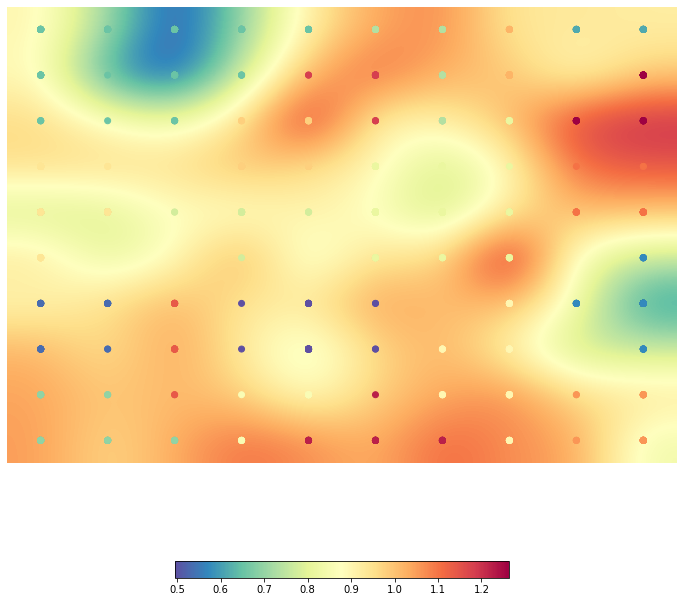

[[ 4  4  4  4  4  6  6 13  3  3]
 [ 4  4  4  4 17 17  6 13  3 19]
 [ 4  4  4 12 12 17  6  8 19 19]
 [11 11 12 12 12  8  8  8 15 15]
 [11 11  7  7  7  8  8  8 15 15]
 [11 11  7  7  8  8  8  8  2  2]
 [ 1  1 16  0  0  0 10 10  2  2]
 [ 1  1 16  0  0  0 10 10  2  2]
 [ 5  5 16  9  9 18 10 10 14 14]
 [ 5  5  5  9 18 18 18 10 14 14]] 

Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[13  9 17 16 19  3  6 18 14 15  1  5  7 12 11  2  0 10  8  4]
 [ 2  3  3  3  3  3  4  4  4  4  4  5  5  5  6  6  6  7 11 12]]



In [31]:
n_movies = 1000
n_columns = 10
n_clusters = 20
evaluate_som('som_movies_{}_columns_{}_clusters_{}.pkl'.format(n_movies, n_columns, n_clusters), matrix_only=True)

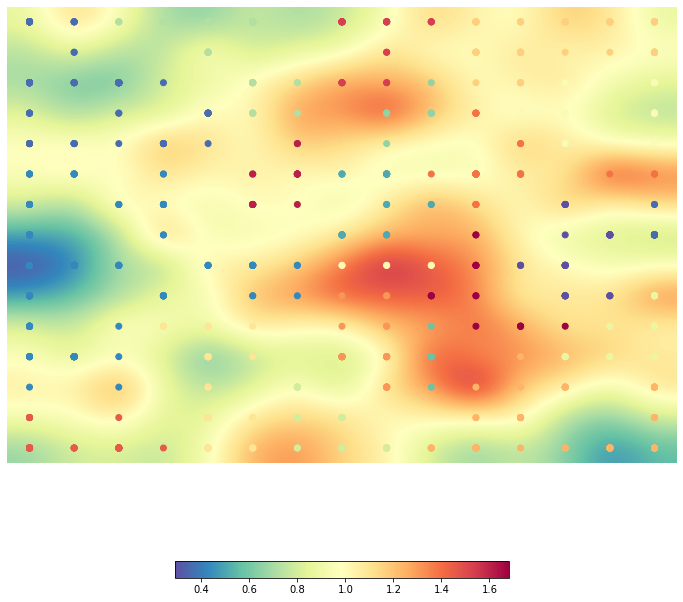

[[ 1  1  6  6  6  6 17 17 17 17 12 12 12 12 12]
 [ 1  1  1  6  6  6  6 17 17 17 12 12 12 12 12]
 [ 1  1  1  1  6  6  6 17 17  5 12 12  9  9  9]
 [ 1  1  1  1  1  6  6  5  5  5 15  9  9  9  9]
 [ 1  1  1  1  1  6 18  3  5  5 15 15  9  9  9]
 [ 2  2  2  2 18 18 18  3  3 15 15 15 15 15 15]
 [ 2  2  2  2 18 18 18  3  3  3 15 15  0  0  1]
 [ 2  2  2  2  2  2  3  3  3  3 19  0  0  0  1]
 [ 2  2  2  2  2  2  2 10 10 10 19  0  0  0  1]
 [ 2  2  2  2  2  2  2 14 14 19 19 19  0  0  8]
 [ 2  2  2 11 11 11 14 14 14  4 19 19 19  8  8]
 [ 2  2  2 11 11 11 14 14 14  4  4 13  8  8  8]
 [ 2  2  2 11 11 11  7 14 14  4 13 13 13 13 13]
 [16 16 16 11 11 11  7  7  7 13 13 13 13 13 13]
 [16 16 16 16 11 11  7  7  7 13 13 13 13 13 13]] 

Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[10  4  5  8 16  7 18 19 17 14  0  3  9 15 12 11  6 13  1  2]
 [ 3  4  6  6  7  7  7  8  9 10 10 10 10 11 12 14 14 18 22 37]]



In [32]:
n_movies = 1000
n_columns = 15
n_clusters = 20
evaluate_som('som_movies_{}_columns_{}_clusters_{}.pkl'.format(n_movies, n_columns, n_clusters), matrix_only=True)

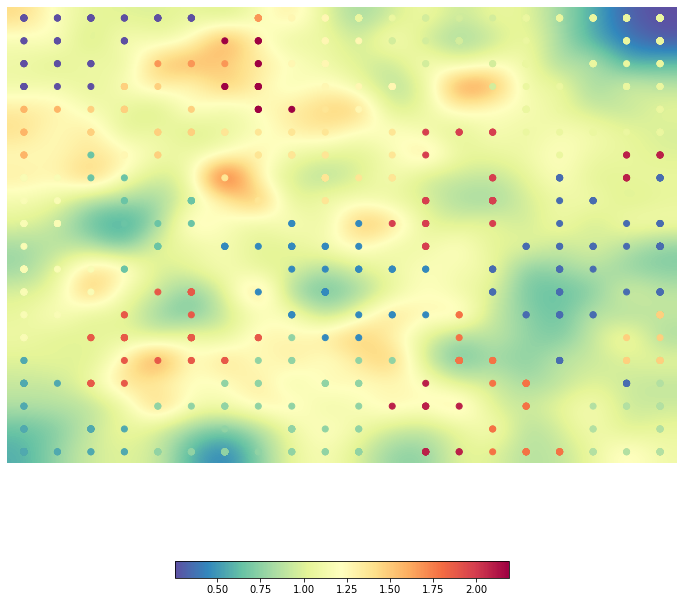

[[ 0  0  0  0  0  0 14 14 10 10  8  8  7  7  7  8  8  8  8  8]
 [ 0  0  0  0  0 14 19 19 10 10 10  7  7  7  7  8  8  8  8  8]
 [ 0  0  0  0 14 14 14 19 10 10 10 10  7  7  7  8  8  8  8  8]
 [ 0  0  0 12 12 14 19 19 19 10 10 10 10  7  7  8  8  8  8  8]
 [13 13 12 12 12 12 19 19 19 11 10 10  8 17  8  8  8  8  8  8]
 [13 13 12 12 12 12 11 11 11 11 11 11 17 17 17  8  8  8  8  8]
 [13 13  4 10 12 12 11 11 11 11 11 11 17 17 17  8  8  8 18 18]
 [ 9  9  4  4  4  4 11 11 11 11 11 11 17 17 17  1  1  1 18  1]
 [ 9  9  4  4  4  4  4 11 11 11 11 17 17 17 17 17  1  1  1  1]
 [ 9  9  4  4  4  4  2  2  2  2  2 17 17 17 17  1  1  1  1  1]
 [ 9  9  4  4  4  4  2  2  2  2  2  2 17 17  1  1  1  1  1  1]
 [ 9  9  9  4  4 16  2  2  2  2  2  2  2  1  1  1  1  1  1  1]
 [ 9  9  9 16 16 16 16  2  2  2  2  2  2  1  1  1  1  1  1  1]
 [ 9  9 16 16 16 16 16  2  2  2  2  2  2 15  1  1  1  1 12 12]
 [ 9  9 16 16 16 16 16 16  5  2  2  2 15 15 15  1  1  1 12 12]
 [ 3  3 16 16 16 16 16  5  5  5  5  5 15 15 15 15  1  1

In [33]:
n_movies = 1000
n_columns = 20
n_clusters = 20
evaluate_som('som_movies_{}_columns_{}_clusters_{}.pkl'.format(n_movies, n_columns, n_clusters), matrix_only=True)

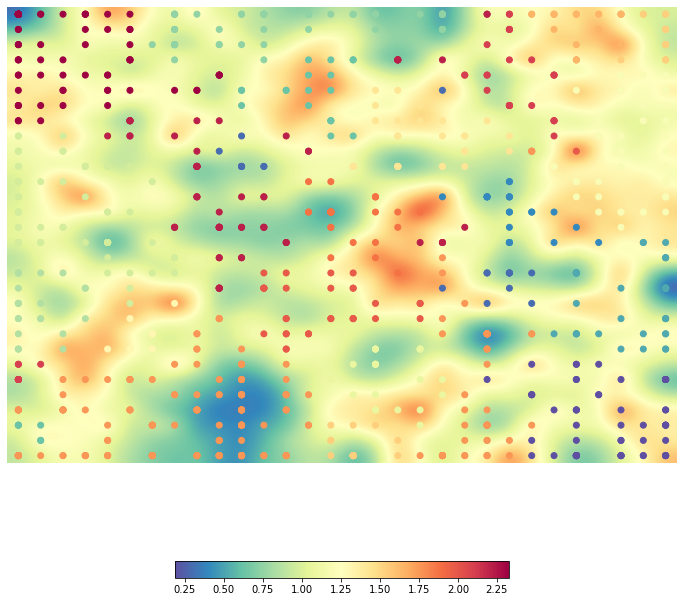

[[19 19 19 19 19 19  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 18 17 13 13 13 13 13 12 12]
 [19 19 19 19 19 19  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 17 17 17 13 13 13 13 12 12]
 [19 19 19 19 19 19  5  5  5  5  5  5  5  4  4  4  5 18 18  5  5 17 17 17 13 13 13 13 12 12]
 [19 19 19 19 19 19 19  5  5 19  5  5  4  4  4  4 18 18 18 18 18 17 17 17 17 13 13 12 12 12]
 [19 19 19 19 19 19 19 19 19 19  4  4  4  4  4  4 11 18 18  1 17 17 17 17 17 17  9  9  9  9]
 [19 19 19 19 19 19 19 19 19  4  4  4  4  4  4  4 11 11 11  1 17 17 17 17 17  9  9  9  9  9]
 [19 19 19 19 19 18 18 19 19  4  4  4  4  4  4 11 11 11 11 11 11 17 17 17 17  9  9  9  9  9]
 [19 19 19 19 18 18 18 18 18 18  4  4  4  4  4  4 11 11 11 11 11 11 17 17 17  9  9  9  9  9]
 [ 7 19  7  7 18 18 18 18 18  1  1 18 18  4  4  4 11 11 11 11 11 11 11 14 17  9  9  9  9  9]
 [ 7  7  7  7  7  7 18 18 18  1  1  1 18 18  4 11 11 11 11 11 11 11 11 14 14 16  9  9  9  9]
 [ 7  7  7  7  7  7  7 18 18 18  1  1  1 18 18 11 11 11 11 11 11 11  2

In [34]:
n_movies = 1000
n_columns = 30
n_clusters = 20
evaluate_som('som_movies_{}_columns_{}_clusters_{}.pkl'.format(n_movies, n_columns, n_clusters), matrix_only=True)

Με βάση τους παραπάνω χάρτες βλέπουμε ότι οι διαστάσεις του χάρτη είναι πολύ μεγάλες ή πολύ μικρές τότε χαλάει η ποιότητα του. Σε μεγαλύτερες διαστάσεις ο χάρτης τείνει να έχει μόνο μπλε-πράσινες περιοχές, ενώ σε μικρότερες διαστάσεις έχει περισσότερες κόκκινες περιοχές. 

Για τα $1000$ δείγματα παίρνουμε μία αξιόλογη ποιότητα χάρτη για διαστάσεις $15\times 15$. 

Ας δούμε τι συμβαίνει αν αυξήσουμε το πλήθος των δειγμάτων. 

### Πλήθος Δειγμάτων

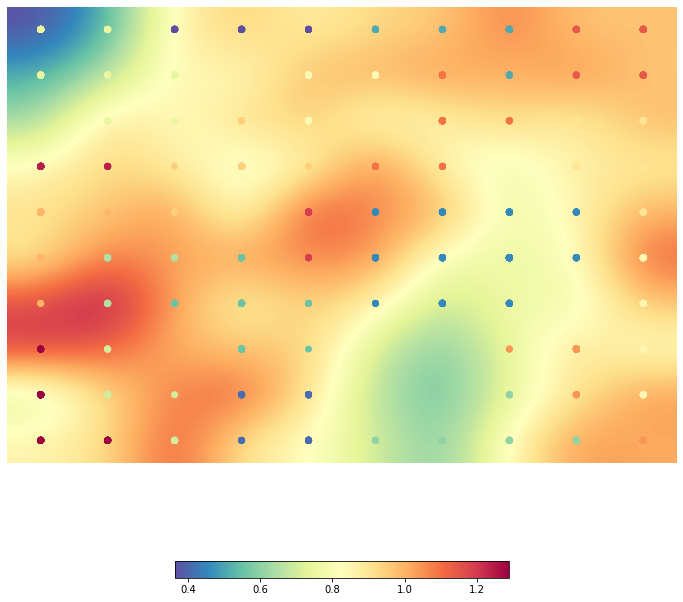

[[ 8  8  0  0  0  3  3  3 16 16]
 [ 8  8  8  0  9  9 15  3 16 16]
 [18  8  8 12  9 15 15 15 11 11]
 [18 18 12 12 12 15 15  2 11 11]
 [13 13 12 12 17  2  2  2  2 11]
 [13  6  6  4 17  2  2  2  2 10]
 [13  6  4  4  4  2  2  2 14 10]
 [19  7  4  4  4  5  5 14 14 10]
 [19  7  7  1  1  5  5  5 14 10]
 [19 19  7  1  1  5  5  5  5 14]] 

Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[17  9 18  6 16 13 10  0  3  1  7 19 11 14 12 15  8  4  5  2]
 [ 2  3  3  3  4  4  4  4  4  4  4  4  5  5  6  6  7  7  9 12]]



In [35]:
n_movies = 2000
n_columns = 10
n_clusters = 20
evaluate_som('som_movies_{}_columns_{}_clusters_{}.pkl'.format(n_movies, n_columns, n_clusters), matrix_only=True)

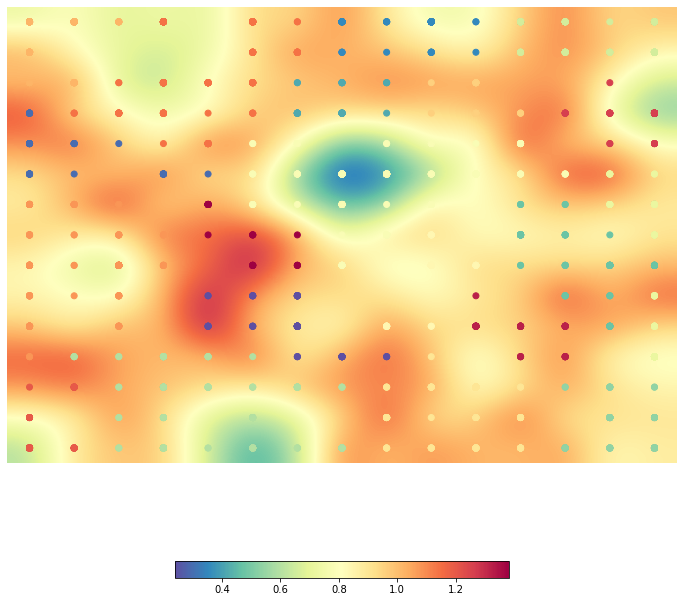

[[13 13 13 15 15 15 15  2  2  2  2  7  7  7  7]
 [13 13 13 15 15 15 15  2  2  2  2  7  7  7  7]
 [13 13 15 15 15 15  3  3  3 12 12 12  7 17 17]
 [ 1 15 15 15 15 15  3  3  3 12 12 12 17 17 17]
 [ 1  1  1 15 15  9  9  9  9  9  9  9 17 17 17]
 [ 1  1  1  1  1  9  9  9  9  9  9  9  9  8  8]
 [14 14 14  1 19  9  9  9  9  9  9  4  4  8  8]
 [14 14 14 14 19 19 19  9  9 10  4  4  4  4  8]
 [14 14 14 14 19 19 19  9 10 10 10  4  4  4  4]
 [14 14 14 14  0  0  0  9 10 10 18 18  4  4  8]
 [14 14 14  6  0  0  0  0 10 10 18 18 18  4  8]
 [14  6  6  6  6  6  0  0  0 11 11 18 18  8  8]
 [16 16  6  6  6  6  6  6 11 11 11 11  5  5  5]
 [16 16  6  6  6  6  6  6 11 11 11 11  5  5  5]
 [16 16  6  6  6  6  6  6 11 11 11 11  5  5  5]] 

Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[ 3 16 12 19 18 17  2 13 10  5  7  8  0  1  4 11 14 15  6  9]
 [ 6  6  6  7  7  8  8  8  8  9  9  9 10 10 13 14 19 19 24 25]]



In [36]:
n_movies = 2000
n_columns = 15
n_clusters = 20
evaluate_som('som_movies_{}_columns_{}_clusters_{}.pkl'.format(n_movies, n_columns, n_clusters), matrix_only=True)

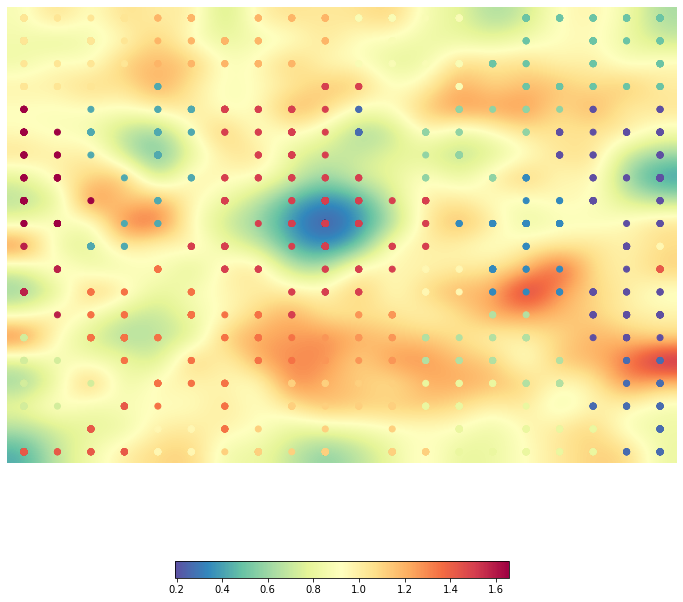

[[11 11 11 11 13 13 13 13 13 13  9  9  9  9  4  4  4  4  4  4]
 [11 11 11 11 13 13 13 13 13 13  9  9  9  9  4  4  4  4  4  4]
 [11 11 11 11 13 13 13 13 13 13  9  9  9  9  4  4  4  4  4  4]
 [11 11 11 11  3  3 17 13 17 17 17  9  9  9  4  4  4  4  4  4]
 [19 19  3  3  3  3 17 17 17 17  1  1  5  5  5  5  5  0  0  0]
 [19 19  3  3  3  3 17 17 17 17  1  1  5  5  5  5  0  0  0  0]
 [19 19  3  3  3  3 17 17 17 17  1  1  5  5  5  5  0  0  0  0]
 [19 19 19  3  3  3 17 17 17 17 17 17  5  5  5  2  0  0  0  0]
 [19 19 19  3  3 17 17 17 17 17 17 17 17 17  2  2  2  0  0  0]
 [19 19  3  3  3 17 17 17 17 17 17 17 17  2  2  2  2  0  0  0]
 [18  3  3  3 15 17 17 17 17 17 17 17 17  2  2  2  2  0  0 10]
 [18 18 18 15 15 15 17 17 17 17 17 17 10 10  2  2  2  0  0 16]
 [18 18 15 15 15 15 15 15 17 17 17 14 10 10  2  2  2  0  0  0]
 [18 18 15 15 15 15 15 15 17 14 14 14 14  6  6  6  0  0  0  0]
 [ 7  7 15 15 15 15 15 15 15 14 14 14  6  6  6  6  6  0  0  0]
 [ 7  7 15 15 15 15 15 15 15 14 14 14  6  6  6  6  6  1

In [37]:
n_movies = 2000
n_columns = 20
n_clusters = 20
evaluate_som('som_movies_{}_columns_{}_clusters_{}.pkl'.format(n_movies, n_columns, n_clusters), matrix_only=True)

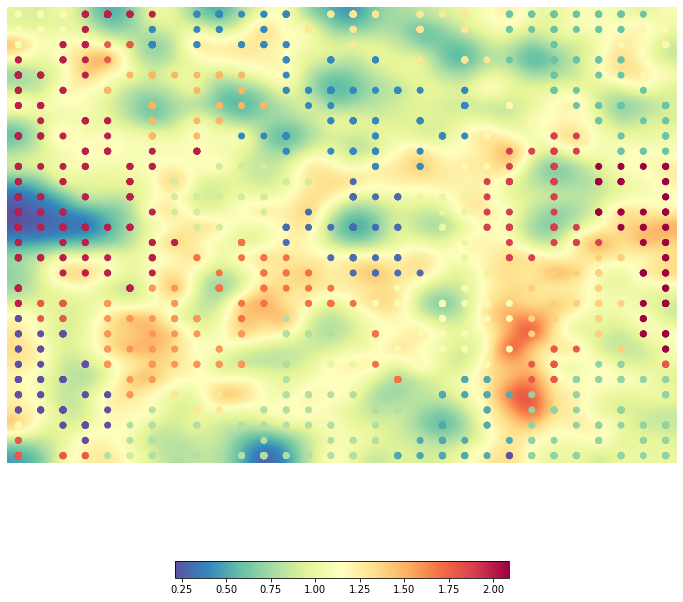

[[ 9  9  9 18 18 18 18  2  2  2  2  2  2 11 11 11 11 11 11 11 11 11  4  4  4  4  4  4  4 10]
 [ 9  9  9 18 18 18  2  2  2  2  2  2  2 11 11 11 11 11 11 11 11 11  4  4  4  4  4  4 10 10]
 [ 9  9 18 18 16 16  2  2  2  2  2  2  2  2  2 11  2 11 11 11 11 11  4  4  4  4  4 10 10 10]
 [18 18 18 18 16 16 13 13 13 13  2  2  2  2  2  2  2 14 11 11 11 11  4  4  4  4  4  4 10 10]
 [18 18 18 18 13 13 13 13 13 13 13  2  2  2  2  2  2  2 11 11 11  2  4  4  4  4  4  4 10 10]
 [18 18 18 18 13 13 13 13 13 13 13 13  2  2  2  2  2  2  2  2  2 10 10  4  4  4  4  4  4  4]
 [18 18 18 18 18 13 13 13 13 13 13 13 13  2  2  2  2  2  2  2  2  2 10 10  4  4  4  4  4  4]
 [18 18 18 18 18 18 13 13 13 13 13 13  2  2  2  2  2  2  2  2  2 10 10 10 17  4  4  4  4  4]
 [18 18 18 18 18 18 13 13 13 13  2  2  2  2  2  2  2  2  2  2  2 10 10 17 17 17  4  4  4  4]
 [18 18 18 18 18 18 18 18 18  7  7  7  2  2  2  2  2  2  2  2 10 10 17 17 17 17  4  4  4  4]
 [18 18 18 18 18 18 18 18 18  7  7  7  7  7  2  2  2  2  2 10 10 10 17

In [38]:
n_movies = 2000
n_columns = 30
n_clusters = 20
evaluate_som('som_movies_{}_columns_{}_clusters_{}.pkl'.format(n_movies, n_columns, n_clusters), matrix_only=True)

Παρατηρούμε ότι όσο αυξάνουμε τα δείγματα τότε τείνουν να αυξάνονται οι κόκκινες περιοχές και να μειώνονται τα clusters. Επομένως, για καλύτερη ποιότητα U-matrix πρέπει να αυξήσουμε τις διαστάσεις του χάρτη. 

Για τα $2000$ δείγματα μία καλή προσέγγιση είναι να πάρουμε χάρτη με διαστάσεις $20\times 20$

### Πλήθος Clusters

Αναφορικά με το πλήθος των clusters, βάζουμε τόσα ώστε να ταιριάζουν με το πλήθος των μπλε-πράσινων περιοχών που έχουμε στο U-matrix. Δοκιμάζουμε k-Means για $10,15,20$ clusters. 

Σημειώνουμε πως δεν μας πειράζει τόσο να βάλουμε μεγαλύτερο αριθμό από clusters από όσα υπάρχουν. Το ανάποδο ωστόσο θα ήταν πρόβλημα γιατί τότε θα υπήρχαν διαφορετικές κατηγορίες ταινιών που θα έμπαιναν στο ίδιο cluster με αποτέλεσμα να μην έχουμε καλό διαχωρισμό.

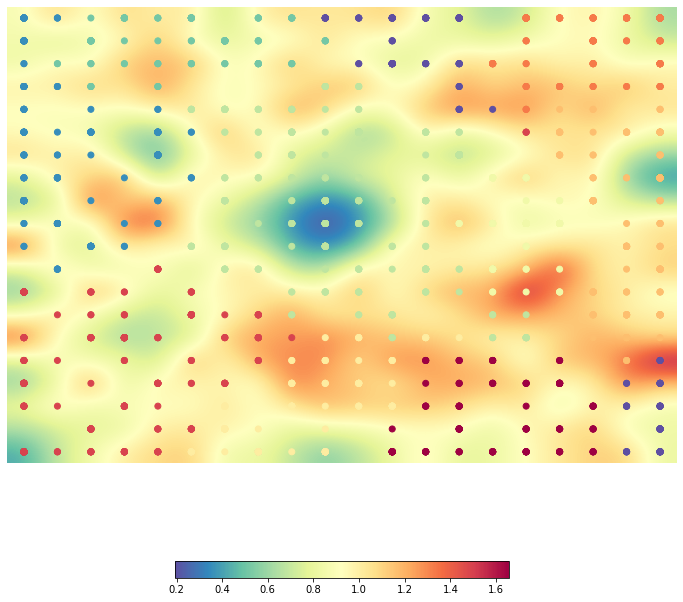

[[1 1 2 2 2 2 2 2 2 0 0 0 0 0 7 7 7 7 7 7]
 [1 2 2 2 2 2 2 2 2 2 0 0 0 0 7 7 7 7 7 7]
 [1 2 2 2 2 2 2 2 2 3 0 0 0 0 7 7 7 7 7 7]
 [1 1 2 2 2 2 3 3 3 3 3 0 0 0 7 7 7 7 7 7]
 [1 1 1 1 1 3 3 3 3 3 3 3 3 0 0 7 6 6 6 6]
 [1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 8 6 6 6 6]
 [1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 4 6 6 6 6]
 [1 1 1 1 1 1 3 3 3 3 3 3 3 3 4 4 4 6 6 6]
 [1 1 1 1 1 3 3 3 3 3 3 3 3 3 4 4 4 6 6 6]
 [1 1 1 1 1 3 3 3 3 3 3 3 3 4 4 4 4 6 6 6]
 [1 1 1 1 8 3 3 3 3 3 3 3 3 4 4 4 4 6 6 6]
 [8 1 1 8 8 8 3 3 3 3 3 3 3 3 4 4 4 6 6 6]
 [8 8 8 8 8 8 8 8 3 3 3 3 3 3 4 4 4 6 6 6]
 [8 8 8 8 8 8 8 8 3 3 3 3 3 3 3 3 6 6 6 6]
 [8 8 8 8 8 8 8 8 8 5 5 3 5 5 3 3 3 6 6 6]
 [8 8 8 8 8 8 8 8 5 5 5 5 9 9 9 9 9 4 6 0]
 [8 8 8 8 8 8 8 5 5 5 5 5 9 9 9 9 9 9 0 0]
 [8 8 8 8 8 8 5 5 5 5 5 5 9 9 9 9 9 9 0 0]
 [8 8 8 8 8 8 5 5 5 5 5 9 9 9 9 9 9 9 0 0]
 [8 8 8 8 8 5 5 5 5 5 5 9 9 9 9 9 9 9 0 0]] 

Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[ 4  7  0  2  5  9  6  1  8  3]
 [22 25 27 28 30 31 38 

In [39]:
n_movies = 2000
n_columns = 20
n_clusters = 10
evaluate_som('som_movies_{}_columns_{}_clusters_{}.pkl'.format(n_movies, n_columns, n_clusters))

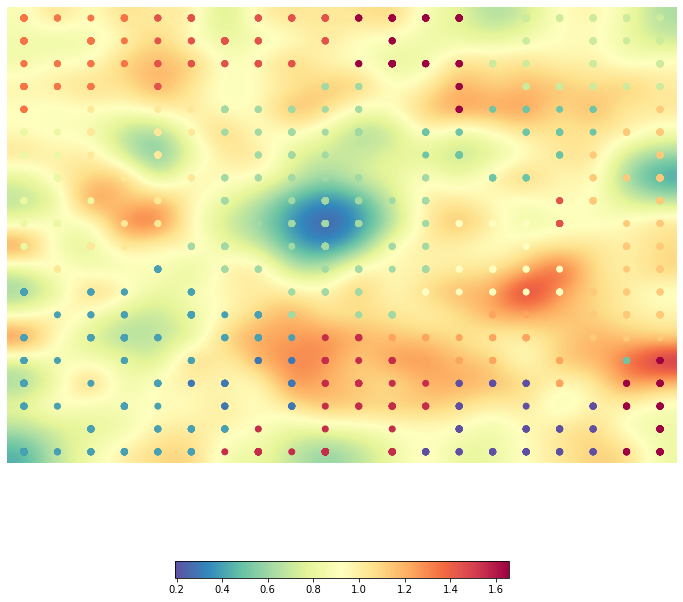

[[11 11 11 11 12 12 12 12 12 12 14 14 14 14  5  5  5  5  5  5]
 [11 11 11 11 12 12 12 12 12 12 14 14 14 14  5  5  5  5  5  5]
 [11 11 11 11 12 12 12 12 12 12 14 14 14 14  5  5  5  5  5  5]
 [11 11 11 11 12 12  4 12  4  4  4 14 14 14  5  5  5  5  5  5]
 [11 11  8  8  8  8  4  4  4  4  4  4  3 14  3  3  3  3  9  9]
 [ 6  6  8  8  8  8  4  4  4  4  4  4  3  3  3  3  3  3  9  9]
 [ 6  6  8  8  8  8  4  4  4  4  4  4  3  3  3  3  3  9  9  9]
 [ 6  6  6  8  8  8  4  4  4  4  4  4  4  3  3  3  3  9  9  9]
 [ 6  6  6  8  8  4  4  4  4  4  4  4  4  4  7  7 12  9  9  9]
 [ 6  6  8  8  8  4  4  4  4  4  4  4  4  7  7  7 12  9  9  9]
 [ 6  8  8  8  2  4  4  4  4  4  4  4  4  7  7  7  7  9  9  9]
 [ 2  8  8  2  2  2  4  4  4  4  4  4  4  7  7  7  7  9  9  9]
 [ 2  2  2  2  2  2  2  4  4  4  4  4  7  7  7  7  7  9  9  9]
 [ 2  2  2  2  2  2  2  2  4  4  4  4 10 10 10 10  9  9  9  9]
 [ 2  2  2  2  2  2  2  2  2 13 13 10 10 10 10 10 10  9  9  9]
 [ 2  2  2  2  2  2  1  1  1 13 13 13 10 10 10 10 10  3

In [40]:
n_movies = 2000
n_columns = 20
n_clusters = 15
evaluate_som('som_movies_{}_columns_{}_clusters_{}.pkl'.format(n_movies, n_columns, n_clusters))

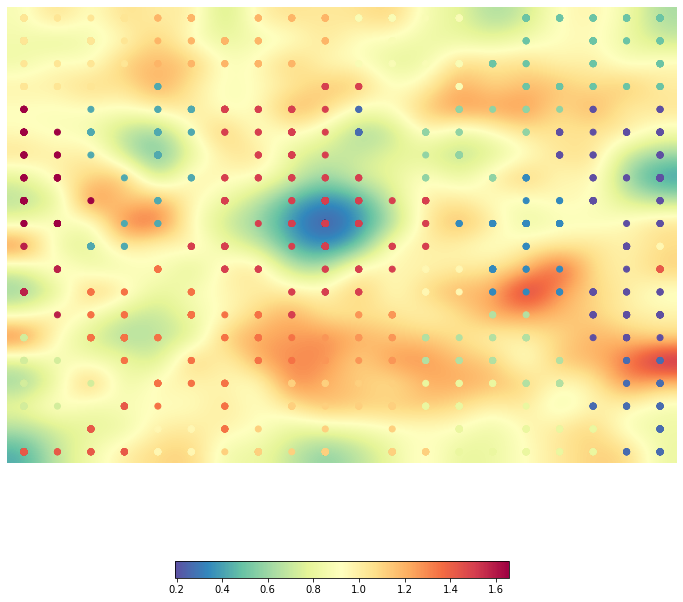

[[11 11 11 11 13 13 13 13 13 13  9  9  9  9  4  4  4  4  4  4]
 [11 11 11 11 13 13 13 13 13 13  9  9  9  9  4  4  4  4  4  4]
 [11 11 11 11 13 13 13 13 13 13  9  9  9  9  4  4  4  4  4  4]
 [11 11 11 11  3  3 17 13 17 17 17  9  9  9  4  4  4  4  4  4]
 [19 19  3  3  3  3 17 17 17 17  1  1  5  5  5  5  5  0  0  0]
 [19 19  3  3  3  3 17 17 17 17  1  1  5  5  5  5  0  0  0  0]
 [19 19  3  3  3  3 17 17 17 17  1  1  5  5  5  5  0  0  0  0]
 [19 19 19  3  3  3 17 17 17 17 17 17  5  5  5  2  0  0  0  0]
 [19 19 19  3  3 17 17 17 17 17 17 17 17 17  2  2  2  0  0  0]
 [19 19  3  3  3 17 17 17 17 17 17 17 17  2  2  2  2  0  0  0]
 [18  3  3  3 15 17 17 17 17 17 17 17 17  2  2  2  2  0  0 10]
 [18 18 18 15 15 15 17 17 17 17 17 17 10 10  2  2  2  0  0 16]
 [18 18 15 15 15 15 15 15 17 17 17 14 10 10  2  2  2  0  0  0]
 [18 18 15 15 15 15 15 15 17 14 14 14 14  6  6  6  0  0  0  0]
 [ 7  7 15 15 15 15 15 15 15 14 14 14  6  6  6  6  6  0  0  0]
 [ 7  7 15 15 15 15 15 15 15 14 14 14  6  6  6  6  6  1

In [41]:
n_movies = 2000
n_columns = 20
n_clusters = 20
evaluate_som('som_movies_{}_columns_{}_clusters_{}.pkl'.format(n_movies, n_columns, n_clusters))

Παρατηρούμε ότι για $k=10$ παίρνουμε clusters που έχουν μεγάλες τιμές εμφανίσεων δύο η παραπάνω κατηγοριών (όχι καλός διαχωρισμός). Για $k=20$, από την άλλη, βλέπουμε ότι κάποιες κατηγορίες εμφανίζονται ως πρωταγωνιστικές σε παραπάνω από $1$ clusters (ύπερ-διαχωρισμός).

Επομένως, μία καλή τιμή που μπορούμε να διαλέξουμε είναι η $k=15$.

Ωστόσο, παρατηρούμε ότι καθώς αυξάνεται το πλήθος των δειγμάτων, οι επιδόσεις του χάρτη τείνουν να χαλάνε. Επομένως, για να το αποφύγουμε αυτό, επιλέγουμε λίγο μεγαλύτερες διαστάσεις του χάρτη και περισσότερα clusters από ο,τι προέκυψε από την ανάλυση μας.

Με βάση τις παραπάνω παρατηρήσεις επιλέγουμε τα εξής χαρακτηριστικά για το τελικό SOM που θα αφορά ολόκληρο το dataset.

```python
n_movies = 5000
n_columns = 30
n_clusters = 20
```



## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM



Για τον τελικό μας χάρτη που θα αφορά ολόκληρο το dataset θα παραθέσουμε τις παρατηρήσεις μας σχετικά με τα τοπολογικά στοιχεία του χάρτη και τα τελικά μας συμπεράσματα για την απόδοση του SOM.

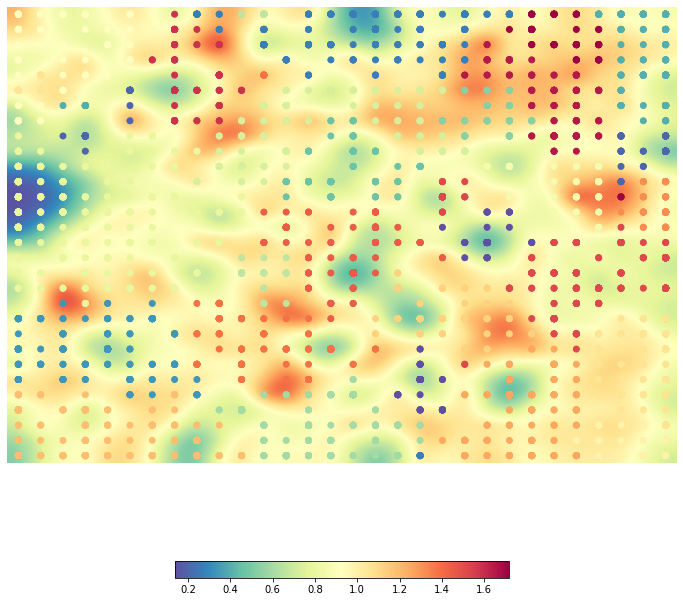

[[12 12 12 12 12 12 12 22  2  2  8  8  8  2  2  2  2  2  2  2  2  2  2 24 24 24  4  4  4  4]
 [12 12 12 12 12 12 22 22 22  2  2  2  2  2  2  2  2  2  2  2  2  2 24 24 24 24 24  4  4  4]
 [12 12 12 12 12 12 22 22 22 22  2  2  2  2  2  2  2  2  2  2  2 23 23 24 24 24 24  4  4  4]
 [12 12 12 12 12 12 22 22 22 22  2  2  2  2  2  2  2  2  2  2  2 23 23 23 24 24 24  4  4  4]
 [12 14 12 12 12  1 22 22 22 22 22 19  2  2  2  2  2  2  2  2 23 23 23 23 23 23  4  4  4  4]
 [14 14 12  4  1  1 22 22 22 22 22 19  9  9  9  9  9  9  9  9  6  6  6 23 23 23 23  4  4  4]
 [12 12  4  4  1  1 22 22 22 22 22  9  9  9  9  9  9  9  9  6  6  6  6 23 23 23 23  4  4  4]
 [12 12 10  1  1  1 22 22 22 22  9  9  9  9  5  5  9  9  9  6  6  6  6  6 23 23 23  1  4  4]
 [10 10  1  1  1 10 10 22 22  9  9  9  9  9  5  5  5  9  9  9  6  6  6 23 23 23 23  1  1  1]
 [10 10 10  1 10 10 10 10 10  9  9  9  9  5  5  5  5  5  9  9  9 11 11 23 23 23  1  1  1  1]
 [10 10 10 10 10 10 10 10 10  9  9  9  9  5  5  5  5  5  5  9  9 11 11

In [42]:
n_movies = 5000
n_columns = 30
n_clusters = 25
evaluate_som('som_movies_{}_columns_{}_clusters_{}.pkl'.format(n_movies, n_columns, n_clusters))

Παρακάτω θα αναλύσουμε τα ζητούμενα τοπολογικά χαρακτηριστικά του χάρτη που παρατίθεται στο προηγούμενο κελί με χρήση συγκεκριμένων παραδειγμάτων από κατηγορίες ταινιών. 

*   Συχνές και μή-συχνές κατηγορίες ταινιών: Κατηγορίες ταινιών οι οποίες είναι πιο συχνές από άλλες τείνουν να χαρακτηρίζονται από cluster με περισσότερους νευρώνες. Για παράδειγμα, στο Cluster $0$ έχουμε κυρίαρχη κατηγορία ταινιών την Comedy film με $86$ ταινίες που αντιστοιχούνται σε $18$ πραγματικούς νευρώνες, ενώ στο cluster $2$ έχουμε την κατηγορία Comedy με $392$ ταινίες και $41$ πραγματικούς νευρώνες. Επιπλεόν, το cluster $10$ που αντιστοιχεί στην κατηγορία drama, η οποία φαίνεται να είναι η επικρατέστερη μεταξύ των ταινιών, απεικονίζεται με $78$ πραγματικούς νευρώνες. 
*   Ταινίες που απέχουν πολύ απεικονίζονται μακριά στον χάρτη: Για παράδειγμα τα clusters $3,4$ απεικονίζονται σε μακρινά σημεία του χάρτη. Το μεν cluster $3$ περιγράφει ταινίες 'World Cinema', 'Drama' και 'Bollywood' (πολυ-πολιτισμικές ταινίες από όλο τον κόσμο) ενώ το δε cluster $4$ περιγράφει ταινίες 'Thriller','Action','Action/Adventure' (ταινίες περιπέτειας και αγωνίας). Πρακτικά, οι ταινίες στα δύο clusters απέχουν πολύ διανυσματικά. Ο χάρτης, λοιπόν, καταφέρνει με επιτυχία να αποτυπώσει αυτήν την ιδιότητα και να τις απεικονίσει απομακρυσμένες. 
*   Υποείδη και παρόμοιες ταινίες απεικονίζονται κοντά στον χάρτη: Παράδειγμα τέτοιων clusters είναι τα $13,14$ όπου το πρώτο έχει ταινίες 'Horror', ενώ το δεύτερο έχει παρόμοιες ταινίες με κύρια κατηγορία 'Thriller' και δεύτερη κατηγορία 'Horror'. Ένα ακόμη παράδειγμα είναι το cluster $5$ που βρίσκεται στο κέντρο του χάρτη. Το Cluster αυτό έχει κυρίαρχη κατηγορία την 'Animation' (κινούμενα σχέδια), ενώ τα συνορέυοντα clusters έχουν αντίστοιχο περιεχόμενο ($9\rightarrow$ 'Family Film', $20\rightarrow$ 'Short-Film', 'Animation' και $21\rightarrow$ 'Japanese-Movies', 'Animation'). Με αυτόν τον τρόπο ο χάρτης μας επιτυγχάνει να παραθέσει ταινίες παρομοίου περιεχομένου πιο κοντά. 

**Ιδιαίτερα Clusters:** Παραδείγμα cluster με όχι κυρίαρχη κατηγορία είναι το $24$ το οποίο έχει κατηγορίες 'Action/Adventure','Action', 'Comedy','World cinema','Martial Arts Film' και 'Chinese Movies' με παρόμοιο πλήθος εμφάνισης. Οι κατηγορίες αυτές ωστόσο, φαίνονται να έχουν προφανή συσχέτιση και να περιγράφουν ταινίες τύπου 'Τσάκι Τσαν' με επιδέξιους κινέζους πολεμιστές/αστυνομικούς.

**Σημαντικά Clusters της συλλογής ταινιών:** Από τα Clusters της συλλογής μας τα κυρίαρχα είναι αυτά που διαθέτουν και τους περισσότερους νευρώνες. Στο δικό μας dataset τα κυρίαρχα cluster είναι τα $10$,$2$, όπου το πρώτο περιγράφει ταινίες 'Drama', ενώ η δεύτερη κωμωδίες. Επίσης, σημαντικό φαίνεται να είναι και σαν κατηγορία το cluster $5$ που τοποθετείται και στο κέντρο του χάρτη και περιγράφει ταινίες κινουμένων σχεδίων. Τα $3$ αυτά clusters περιγράφουν τις κυρίαρχες κατηγορίες του dataset μας. 

**Συμπεράσματα:** Όπως είναι φανερό ο χάρτης επιτυγχάνει το ζητούμενο. Συγκεκριμένα, καταφέρνει να αποτυπώσει σχηματικά την σύνδεση μεταξύ των ταινιών. Δηλαδή, καταφέρνει παρόμοιες ταινίες να τις φέρει κοντά και πολύ διαφορετικές ταινίες να τις απομακρύνει. Επίσης, με το μέγεθος των cluster εκφράζει την πληθικότητα εμφάνισης των ταινιών. Έτσι, ταινίες πιο συχνές εμφανίζονται με μεγαλύτερες περιοχές στον χάρτη.

Ασφαλώς, η αποτύπωση ταινιών σε διδιάστατο χάρτη δεν είναι εφικτή εξ' ορισμού, εφόσον δεν είναι καλά ορισμένη στην πράξη η απόσταση ταινιών αφού αποτελεί μία ανθρώπινη υποκειμενική άποψη. Ωστόσο, ο χάρτης μας επιτυγχάνει μία καλή προσέγγιση αυτής της διαίσθησης. 
